# Modeling BTC

## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

## Loading in and formatting the Data

In [54]:
bc = pd.read_csv('BTC-USD.csv')
bc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


### Converting Dates into a Datetime Format

In [55]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

#### Setting dates as the index

In [56]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,0.04951,0
2010-07-18,0.04951,0.08585,0.05941,0.08584,0.08584,5
2010-07-19,0.08584,0.09307,0.07723,0.08080,0.08080,49
2010-07-20,0.08080,0.08181,0.07426,0.07474,0.07474,20
2010-07-21,0.07474,0.07921,0.06634,0.07921,0.07921,42


#### Selecting only the Closing Price as well as the dates starting from January 2017. 
This is the time when Bitcoin and Cryptocurrency in general started to become popular to trade.

In [57]:
bc = bc[['Close']].loc['2017-01-01':]
bc.head()

,Close
Date,
2017-01-01,995.440002
2017-01-02,1017.049988
2017-01-03,1033.300049
2017-01-04,1135.410034
2017-01-05,989.349976


### Exporting this data for later use

In [58]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

## Plotting and EDA

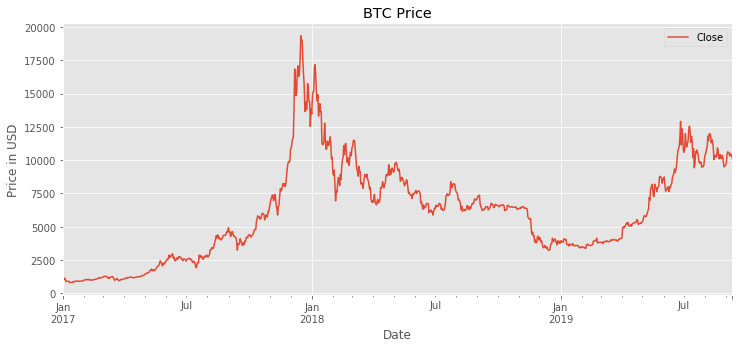

In [59]:
bc.plot(figsize=(12,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('BTC Price')
plt.show()

In [60]:
bc.describe()

,Close
count,983.000000
mean,6078.625359
std,3613.300566
min,785.429993
25%,3558.160034
50%,6209.470215
75%,8235.060059
max,19345.490234


## Detrending

### Method #1 - Differencing the Data

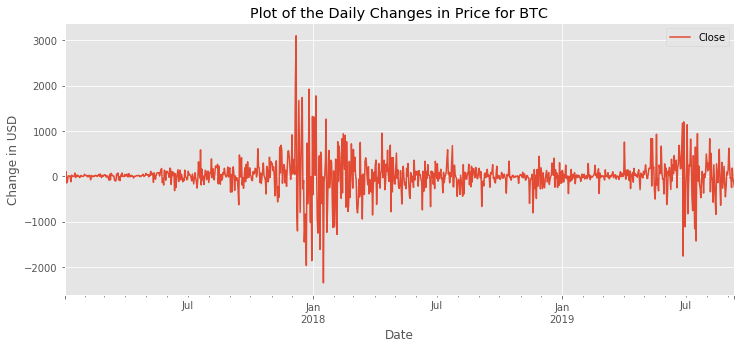

In [61]:
bc_diff = bc.diff(1).dropna()
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

#### Testing for Stationarity

In [62]:
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 1.0705745337703831e-07


### Method #2 - Taking the Log then differencing

In [63]:
bc_log = pd.DataFrame(np.log(bc.Close))

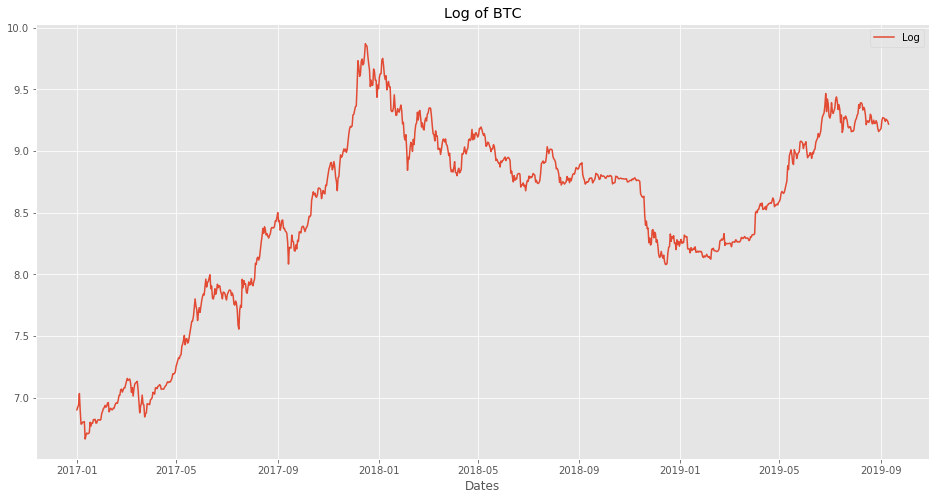

In [64]:
plt.figure(figsize=(16,8))
plt.plot(bc_log, label='Log')
plt.title('Log of BTC')
plt.xlabel('Dates')
plt.legend()
plt.show()

In [65]:
log_diff = bc_log.diff().dropna()

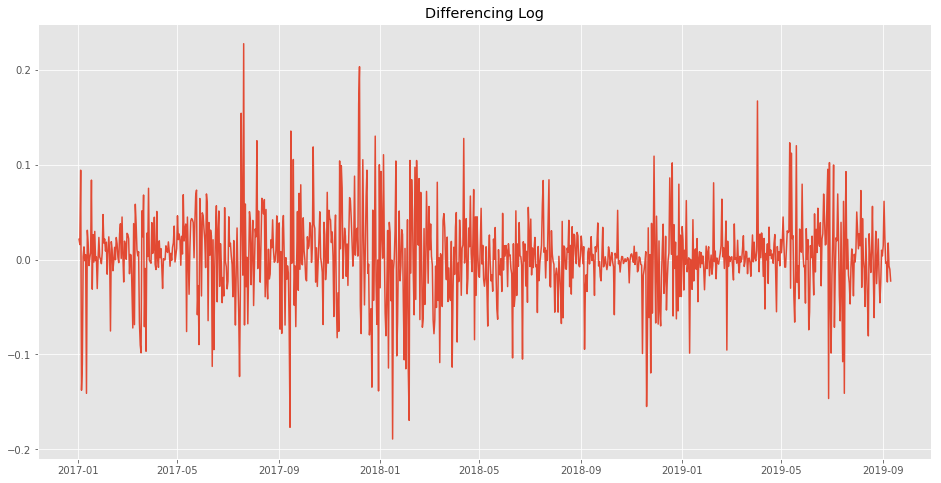

In [66]:
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.show()

#### Testing for Stationarity

In [67]:
results = adfuller(log_diff.Close)
print(f"P-value: {results[1]}")

P-value: 4.3276453306038325e-25


## PACF and ACF

#### ACF and PACF for the Differencing

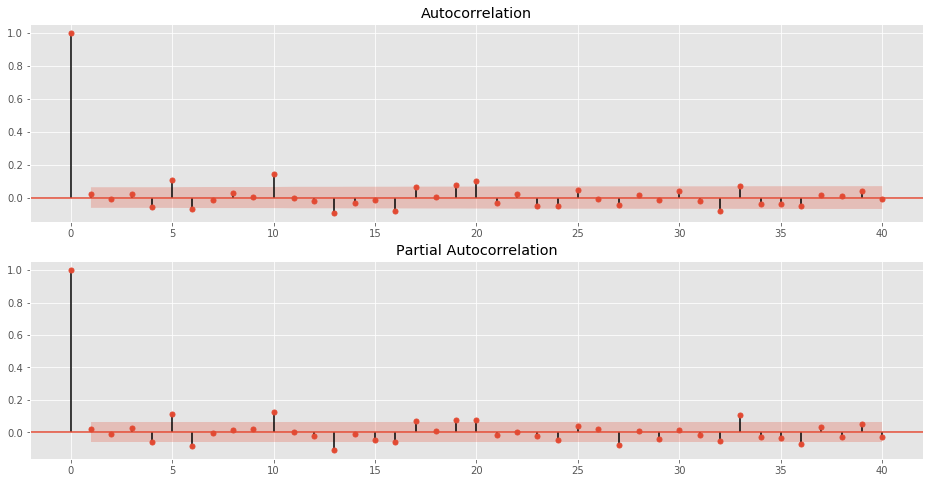

In [68]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc_diff, ax=ax1, lags=40)
plot_pacf(bc_diff, ax=ax2, lags=40)
plt.show()

Not much correlation, if none at all, between the current price and the prices from N days ago.

#### ACF and PACF for the Log Difference

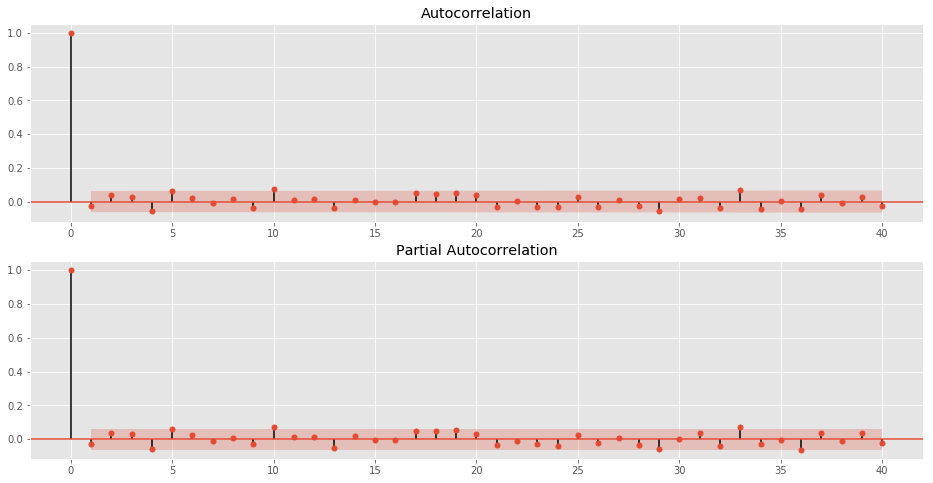

In [69]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(log_diff, ax=ax1, lags=40)
plot_pacf(log_diff, ax=ax2, lags=40)
plt.show()

## Modeling

## ARIMA Model for Differencing

### Finding the Best Parameters for ARIMA

In [70]:
def best_param(model, data, pdq, pdqs):
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [106]:
p = d = q = range(0,8)
#d = 0
pdq = list(itertools.product(p, d, q))
pdq = [(2, 1, 3)]

pdqs = [(i[0],i[1],i[2], 12) for i in itertools.product(range(0,4), repeat=3)]
#pdqs = [(0,0,0,0)]


In [107]:
best_param(SARIMAX, bc_log, pdq, pdqs)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

pdq         (2, 1, 3)
pdqs    (0, 0, 0, 12)
aic          -3310.51
Name: 0, dtype: object

#### Best Parameters according to the function

In [26]:
# pdq        (2, 1, 3)
# pdqs    (0, 0, 0, 0)
# aic         -3310.51

### Fitting and Training SARIMAX

In [145]:
index = round(len(bc)*.90)

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

In [146]:
model = SARIMAX(train, 
                order=(0, 1, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fitting the model with weekly seasonality consumes plenty of processing power.  Time to finish is usually 5 minutes for fitting just one model.

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  885
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1489.488
Date:                Wed, 25 Sep 2019   AIC                          -2976.976
Time:                        18:54:24   BIC                          -2972.193
Sample:                    01-01-2017   HQIC                         -2975.147
                         - 06-04-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0020   6.09e-05     32.915      0.000       0.002       0.002
Ljung-Box (Q):                       57.05   Jarque-Bera (JB):               316.72
Prob(Q):                              0.04   Pr

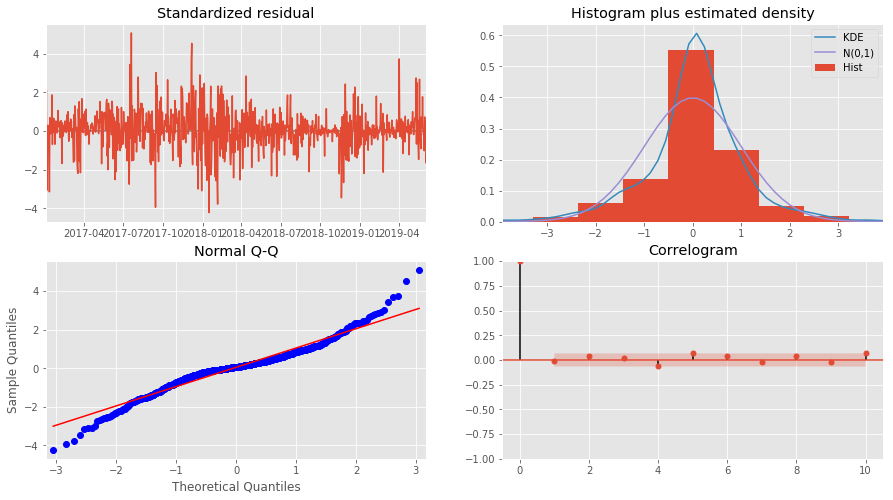

In [147]:
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

### Predictions with ARIMA

In [152]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2018'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))



/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


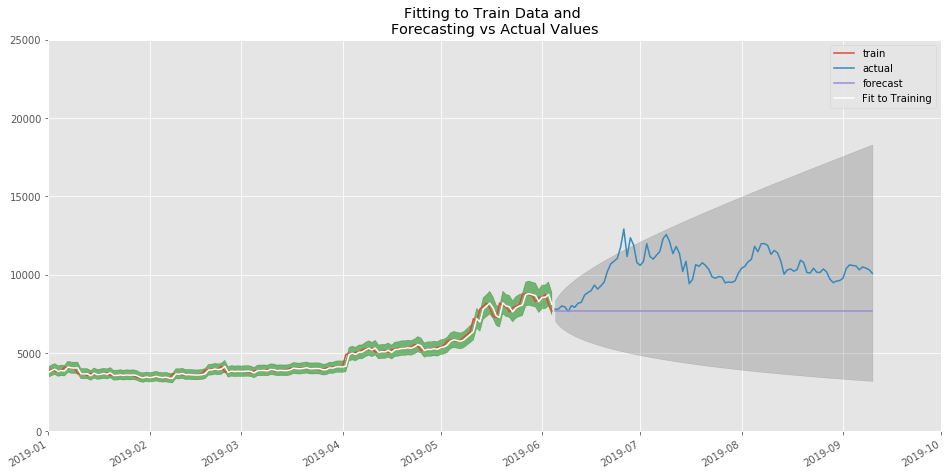

In [153]:
#plt.figure(figsize=(16,8))
rcParams['figure.figsize'] = 16, 8

plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

plt.xlim(['2019-01', '2019-10'])
plt.ylim([0, 25000])

plt.title('Fitting to Train Data and \nForecasting vs Actual Values')
plt.legend()
plt.show()

### Calculating the RMSE for SARIMA

In [116]:
forecast = pred
actual_val = etrain.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  340.54471597605


### Forecasting Future Values

In [117]:
model = SARIMAX(bc_log, 
                order=(2, 1, 3), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [118]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)
# Confidence interval for our forecasted values
pred_conf = future.conf_int()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


#### Plotting the forecasted values

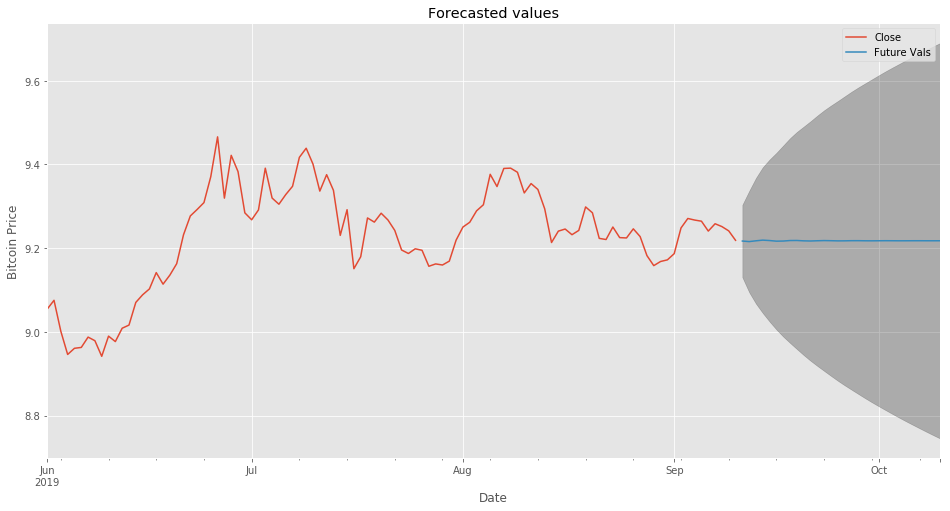

In [119]:
ax = bc_log['2019-06-01':].plot(label='Actual', figsize=(16,8))
future.predicted_mean.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')

plt.title('Forecasted values')
plt.legend()
plt.show()

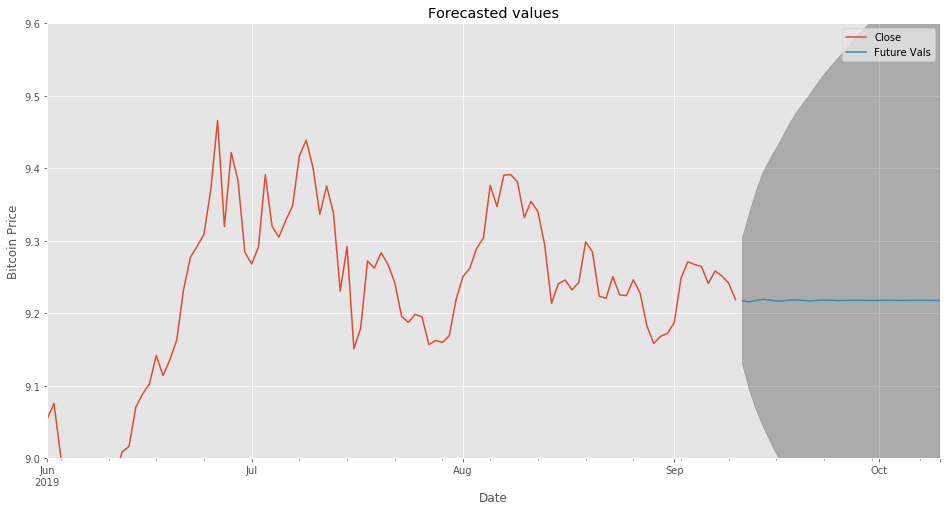

In [120]:
# Graph zoomed in

ax = bc_log['2019-06-01':].plot(label='Actual', figsize=(16,8))
future.predicted_mean.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_ylim([9,9.6])

plt.title('Forecasted values')
plt.legend()
plt.show()

## Modeling ARIMA again

In [121]:
from statsmodels.tsa.arima_model import ARIMA

#### Train, Test, Split

In [193]:
index = round(len(bc)*.90)

# train = bc.iloc[:index]
# test = bc.iloc[index:]

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

#### Optimal Parameters for the Training set

In [194]:
p = q = range(0,4)
d = [0,1,2]
pdq = list(itertools.product(p, d, q))


param, p = best_param(ARIMA, train, pdq)

print(p)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



pdq    (0, 1, 0)
aic     -2981.48
Name: 4, dtype: object


#### Fitting to the training set

In [195]:
mod = ARIMA(train, 
            order=param, 
            freq='D')
out = mod.fit()

In [196]:
print(out.summary())
# out.plot_diagnostics(figsize=(15,8))
# plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  884
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1492.740
Method:                           css   S.D. of innovations              0.045
Date:                Thu, 26 Sep 2019   AIC                          -2981.479
Time:                        10:17:45   BIC                          -2971.910
Sample:                    01-02-2017   HQIC                         -2977.820
                         - 06-04-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.537      0.125      -0.001       0.005


#### Forecasting from the training set

In [197]:
fc, se, conf = out.forecast(len(test), alpha=.05)

In [198]:
fc_series    = np.exp(pd.Series(fc, index=test.index))
lower_series = np.exp(pd.Series(conf[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf[:, 1], index=test.index))

train = np.exp(train)
test  = np.exp(test)

#### Plotting the forecast compared to the Test set

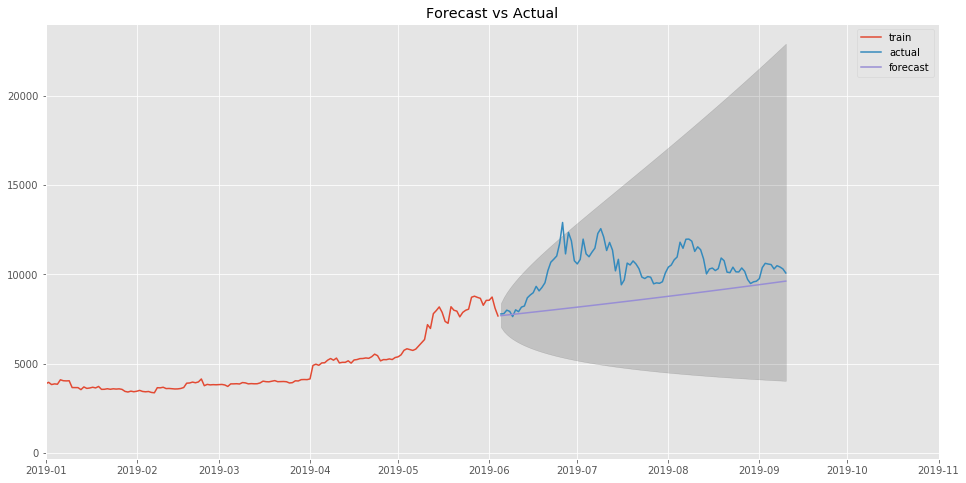

In [199]:
plt.figure(figsize=(16,8))
plt.plot(train, label='train')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.xlim(['2019-01', '2019-11'])

plt.title('Forecast vs Actual')
plt.legend()
plt.show()